# RECONOCIMIENTO FACIAL

In [1]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
import os  
# Configurar TensorFlow para usar todos los hilos de la CPU antes de inicializarlo
cpu_cores = os.cpu_count()  # Detectar cuántos núcleos tiene tu CPU
os.environ["TF_NUM_INTEROP_THREADS"] = str(cpu_cores)
os.environ["TF_NUM_INTRAOP_THREADS"] = str(cpu_cores)

import tensorflow as tf  # Importamos TensorFlow después de configurar las variables

# Usar estrategia de entrenamiento en CPU (no usar MirroredStrategy)
strategy = tf.distribute.OneDeviceStrategy(device="/cpu:0")  # Optimiza la CPU

# Activar XLA para mejorar velocidad
tf.config.optimizer.set_jit(True)  

print(f"Usando {cpu_cores} hilos de CPU para entrenamiento.")
print(f"Se utilizará la estrategia {strategy} en la CPU.")

Carpetas en D:/taller/dataset/: ['001_Kevin', '002_luis', '003_christian', '004_frank', '005_david', '006_VictorGarber', '007_TomHanks', '008_TobeyMaguire', '009_TaylorLautner', '010_WoodyAllen']


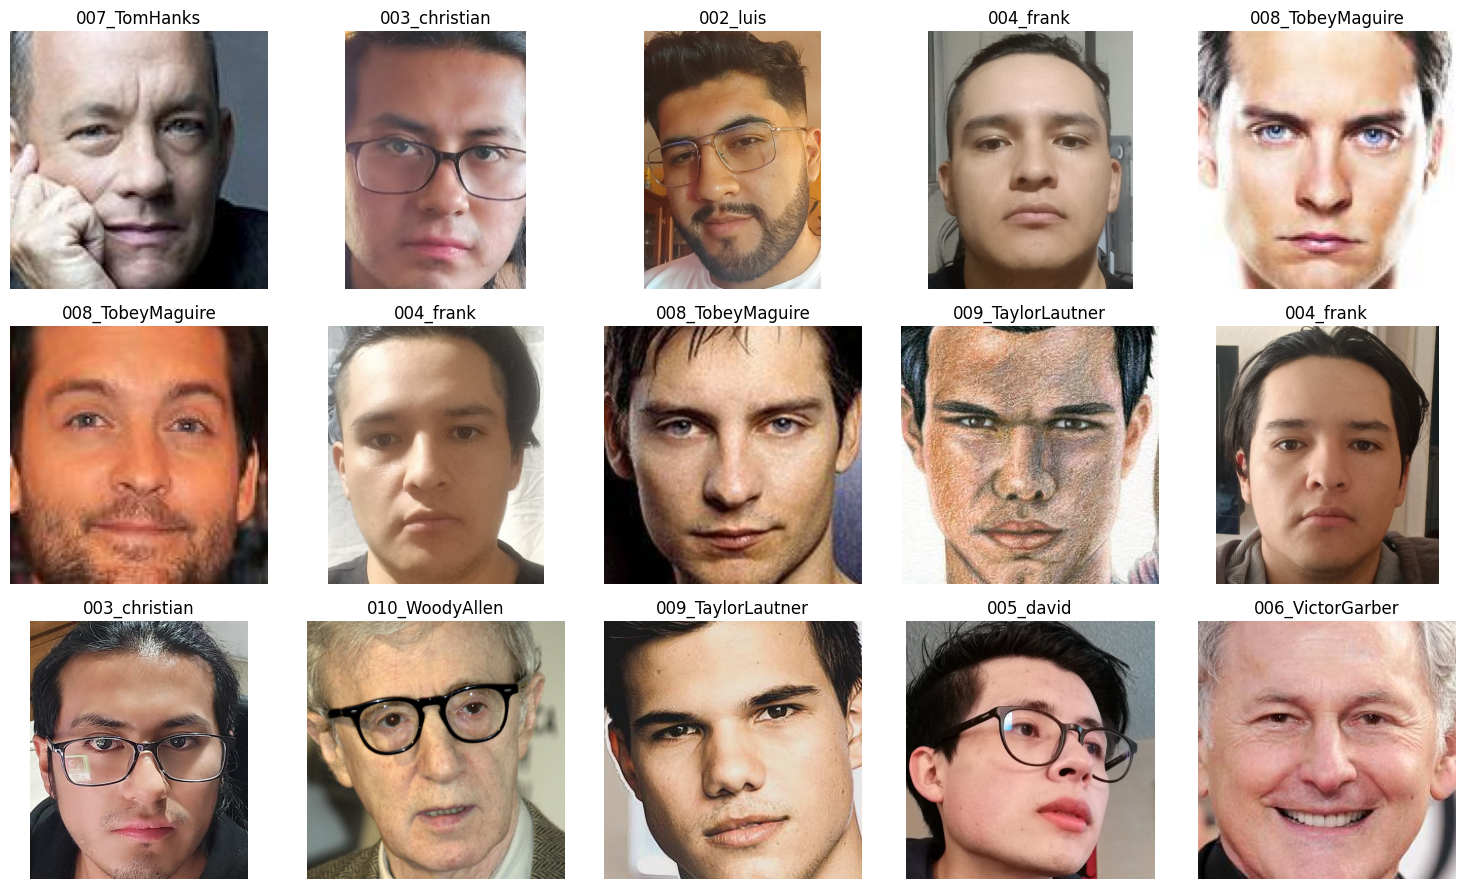

In [2]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Rutas de los datos
fotos_mias = "D:/taller/dataset/"  # Tus fotos
if not os.path.exists(fotos_mias):
    print(f"⚠️ Error: La carpeta '{fotos_mias}' no existe.")
else:
    fotos_mias_folders = os.listdir(fotos_mias)
    print(f"Carpetas en {fotos_mias}: {fotos_mias_folders}")


# Listado de carpetas en fotos_mias (asumimos que cada carpeta es una persona)
fotos_mias_folders = os.listdir(fotos_mias)


# Seleccionar 15 imágenes aleatorias
total_images = 15
selected_images = []

# Seleccionar imágenes de fotos_mias
for folder in fotos_mias_folders:
    folder_path = os.path.join(fotos_mias, folder)
    if os.path.isdir(folder_path):
        images = os.listdir(folder_path)
        for img in images:
            selected_images.append((os.path.join(folder_path, img), folder))

if len(selected_images) < total_images:
    print(f"⚠️ Advertencia: Solo hay {len(selected_images)} imágenes disponibles, no {total_images}. Se usarán todas las disponibles.")
    total_images = len(selected_images)  # Ajustar total_images a la cantidad real disponible

selected_images = random.sample(selected_images, total_images)
# Seleccionar 15 imágenes aleatorias
selected_images = random.sample(selected_images, total_images)

# Plotear las imágenes
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
axes = axes.flatten()

for (img_path, label), ax in zip(selected_images, axes):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [3]:
import os
import numpy as np

# Listas para los archivos y las etiquetas
fotos_mias_files = []
fotos_mias_attri = []

# Asignar una etiqueta única a cada persona basada en el valor numérico de la carpeta
for folder in fotos_mias_folders:
    folder_path = os.path.join(fotos_mias, folder)
    if os.path.isdir(folder_path):
        # Extraer el número del nombre de la carpeta (asumiendo formato 001_Nombre)
        folder_number = int(folder.split('_')[0])
        
        # Listar todas las imágenes dentro de la subcarpeta
        files_in_folder = os.listdir(folder_path)
        for file in files_in_folder:
            fotos_mias_files.append(os.path.join(fotos_mias, folder, file))  # Ruta completa de la imagen
            fotos_mias_attri.append(folder_number)  # Asignar una etiqueta basada en el número de la carpeta

fotos_mias_files = np.array(fotos_mias_files)
fotos_mias_attri = np.array(fotos_mias_attri)


# Imprimir los arrays generados
print("fotos_mias_files_array:")
print(fotos_mias_files)

print("\nfotos_mias_attri_array:")
print(fotos_mias_attri)

fotos_mias_files_array:
['D:/taller/dataset/001_Kevin\\001_Kevin.jpg'
 'D:/taller/dataset/001_Kevin\\002_Kevin.jpg'
 'D:/taller/dataset/001_Kevin\\003_Kevin.jpg'
 'D:/taller/dataset/001_Kevin\\004_Kevin.jpg'
 'D:/taller/dataset/001_Kevin\\005_Kevin.jpg'
 'D:/taller/dataset/001_Kevin\\006_Kevin.jpg'
 'D:/taller/dataset/001_Kevin\\007_Kevin.jpg'
 'D:/taller/dataset/001_Kevin\\008_Kevin.jpg'
 'D:/taller/dataset/001_Kevin\\009_Kevin.jpg'
 'D:/taller/dataset/001_Kevin\\010_Kevin.jpg'
 'D:/taller/dataset/001_Kevin\\011_Kevin.jpg'
 'D:/taller/dataset/001_Kevin\\012_Kevin.jpg'
 'D:/taller/dataset/001_Kevin\\013_Kevin.jpg'
 'D:/taller/dataset/001_Kevin\\014_Kevin.jpg'
 'D:/taller/dataset/001_Kevin\\015_Kevin.jpg'
 'D:/taller/dataset/001_Kevin\\016_Kevin.jpg'
 'D:/taller/dataset/001_Kevin\\017_Kevin.jpg'
 'D:/taller/dataset/001_Kevin\\018_Kevin.jpg'
 'D:/taller/dataset/001_Kevin\\019_Kevin.jpg'
 'D:/taller/dataset/001_Kevin\\020_Kevin.jpg'
 'D:/taller/dataset/001_Kevin\\021_Kevin.jpg'
 'D:/talle

In [4]:
import keras
from keras import layers, models
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Dropout,Activation,MaxPooling2D,Flatten
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf


import matplotlib.pyplot as plt
import numpy as np

ih = 128
iw = 128

percent = 0.15

BATCH_SIZE = 32
epochs = 20

N_d = 100

STEPS_PER_EPOCH =  int(((len(fotos_mias_folders)+1)*N_d*(1-percent)) // BATCH_SIZE)
VALIDATION_STEPS = int(((len(fotos_mias_folders)+1)*N_d * percent) // BATCH_SIZE)
#==============================================================================
#                               procesamiento de Datos


fotos_mias_files = tf.data.Dataset.from_tensor_slices(fotos_mias_files)
fotos_mias_attri = tf.data.Dataset.from_tensor_slices(fotos_mias_attri)

fotos_mias_data = tf.data.Dataset.zip((fotos_mias_files,fotos_mias_attri))


def process_file_fotos_mias(file_name, fotos_mias_attri):
    print(fotos_mias)
    image = tf.io.read_file(file_name)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [ih,iw])
    image /= 255.0
    return image, fotos_mias_attri

labeled_images_fotos_mias = fotos_mias_data.map(process_file_fotos_mias)

labeled_images = labeled_images_fotos_mias
labeled_images = labeled_images.shuffle((len(fotos_mias_folders)+1)*N_d)

print('=======================================================================')

print('labeled_images:')
print(labeled_images)
print('labeled_images_len:')
print(len(labeled_images))

print('=======================================================================')

dataset_size = int(N_d* (len(fotos_mias_folders)+1)* (1-percent))

training_data = labeled_images.take(dataset_size)
training_data = training_data.repeat().batch(BATCH_SIZE)

test_data = labeled_images.skip(dataset_size)
test_data = test_data.repeat().batch(BATCH_SIZE)

print('=======================================================================')
print('split dataset in training and test data')

print('training_data')
print(training_data)

print('test_data')
print(test_data)

print('=======================================================================')
#==============================================================================

D:/taller/dataset/
labeled_images:
<_ShuffleDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
labeled_images_len:
270
split dataset in training and test data
training_data
<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
test_data
<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [5]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
import datetime
import os
import numpy as np
from sklearn.model_selection import train_test_split

# 📂 Definir la ruta donde están almacenadas las imágenes de entrenamiento
fotos_mias = "D:/taller/dataset/"  # Ajusta esta ruta según la ubicación real de tus datos

# 📌 Obtener la lista de carpetas dentro de la ruta de imágenes
fotos_mias_folders = [folder for folder in os.listdir(fotos_mias) if os.path.isdir(os.path.join(fotos_mias, folder))]

if len(fotos_mias_folders) == 0:
    raise ValueError("❌ Error: No se encontraron carpetas dentro de la ruta de datos.")

print(f"📂 Se encontraron {len(fotos_mias_folders)} carpetas en '{fotos_mias}'.")

# 📌 Crear listas para almacenar rutas de imágenes y sus etiquetas
image_paths = []
labels = []

# Asignar una etiqueta única a cada persona basada en el índice de la carpeta
for label, folder in enumerate(fotos_mias_folders):
    folder_path = os.path.join(fotos_mias, folder)
    images = [os.path.join(folder_path, img) for img in os.listdir(folder_path)]
    
    image_paths.extend(images)
    labels.extend([label] * len(images))  # Asignar la misma etiqueta a todas las imágenes de la carpeta

image_paths = np.array(image_paths)
labels = np.array(labels)

print(f"📌 Total de imágenes: {len(image_paths)}")
print(f"📌 Total de etiquetas: {len(labels)}")

# 📌 Dividir en entrenamiento y validación (80% entrenamiento, 20% validación)
train_images, val_images, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

# 📌 Función para cargar y procesar imágenes
def process_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    image = image / 255.0  # Normalizar valores entre 0 y 1
    return image, label

# 📌 Crear datasets de entrenamiento y validación
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

training_data = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
training_data = training_data.map(process_image, num_parallel_calls=AUTOTUNE)
training_data = training_data.shuffle(len(train_images)).batch(BATCH_SIZE).prefetch(AUTOTUNE)

test_data = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
test_data = test_data.map(process_image, num_parallel_calls=AUTOTUNE)
test_data = test_data.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# 📌 Definir pasos por época para evitar errores de StopIteration
STEPS_PER_EPOCH = max(1, len(train_images) // BATCH_SIZE)
VALIDATION_STEPS = max(1, len(val_images) // BATCH_SIZE)

print(f"📌 STEPS_PER_EPOCH: {STEPS_PER_EPOCH}, VALIDATION_STEPS: {VALIDATION_STEPS}")

# 📌 Número de épocas de entrenamiento
epochs = 20  

# ✅ **Definir el modelo**
pre_trained_model = VGG16(weights="imagenet", include_top=False, input_shape=(128, 128, 3))

model = Sequential()

# Añadir capas preentrenadas
for layer in pre_trained_model.layers:
    model.add(layer)

# Añadir capas personalizadas
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(len(fotos_mias_folders), activation="softmax"))  # Ajuste según clases disponibles

# Congelar capas preentrenadas
for layer in model.layers[:-4]:  
    layer.trainable = False

# Compilar el modelo
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=Adam(),
    metrics=["accuracy"],
)

model.summary()

# 📌 Configurar TensorBoard
log_dir = "redes_entrenadas/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# ✅ **Entrenar el modelo**
history = model.fit(
    training_data,
    epochs=epochs,
    steps_per_epoch=STEPS_PER_EPOCH,
    batch_size=BATCH_SIZE,
    validation_data=test_data,
    validation_steps=VALIDATION_STEPS,
    callbacks=[tensorboard_callback],
)


📂 Se encontraron 10 carpetas en 'D:/taller/dataset/'.
📌 Total de imágenes: 270
📌 Total de etiquetas: 270
📌 STEPS_PER_EPOCH: 6, VALIDATION_STEPS: 1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,772,298 (60.17 MB)

 Trainable params: 1,057,610 (4.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 884ms/step - accuracy: 0.1987 - loss: 2.3757 - val_accuracy: 0.5000 - val_loss: 1.6566
Epoch 2/20
1/6 ━━━━━━━━━━━━━━━━━━━━ 2s 404ms/step - accuracy: 0.2083 - loss: 1.8584

C:\Users\pc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 281ms/step - accuracy: 0.2083 - loss: 1.8584 - val_accuracy: 0.4688 - val_loss: 1.6434
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 809ms/step - accuracy: 0.5062 - loss: 1.5664 - val_accuracy: 0.8125 - val_loss: 0.9815
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 272ms/step - accuracy: 0.6667 - loss: 0.9942 - val_accuracy: 0.6562 - val_loss: 0.9807
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 799ms/step - accuracy: 0.7208 - loss: 0.9476 - val_accuracy: 0.8750 - val_loss: 0.5988
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 262ms/step - accuracy: 0.9167 - loss: 0.5042 - val_accuracy: 0.9062 - val_loss: 0.5478
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 792ms/step - accuracy: 0.8493 - loss: 0.5122 - val_accuracy: 0.8125 - val_loss: 0.5443
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 267ms/step - accuracy: 1.0000 - loss: 0.2665 - val_accuracy: 0.8125 - val_loss: 0.5175
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 783ms/step - accuracy: 0.8978 - loss: 0.3157 - val_accuracy: 0.9375 - val_loss: 0.3085
Epo

In [6]:
# Sobrescribir los archivos existentes al guardar los pesos y el modelo
model.save("redes_entrenadas/ReconocimientoFacialV02.h5")

Carpetas en el directorio de imágenes:
['001_Kevin', '002_luis', '003_christian', '004_frank', '005_david', '006_VictorGarber', '007_TomHanks', '008_TobeyMaguire', '009_TaylorLautner', '010_WoodyAllen']

🔍 Mapeo de Clases (Inferencia): {0: '001_Kevin', 1: '002_luis', 2: '003_christian', 3: '004_frank', 4: '005_david', 5: '006_VictorGarber', 6: '007_TomHanks', 7: '008_TobeyMaguire', 8: '009_TaylorLautner', 9: '010_WoodyAllen'}
Mapeo de clases:
Índice 0: 001_Kevin
Índice 1: 002_luis
Índice 2: 003_christian
Índice 3: 004_frank
Índice 4: 005_david
Índice 5: 006_VictorGarber
Índice 6: 007_TomHanks
Índice 7: 008_TobeyMaguire
Índice 8: 009_TaylorLautner
Índice 9: 010_WoodyAllen


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step

🔹 Predicción Cruda: [[0.00349817 0.00783866 0.17627944 0.15215123 0.00385618 0.05173631
  0.4434904  0.13438506 0.00853202 0.01823265]]
🔹 Clase Predicha: 6, Probabilidad: 44.35%
Predicción bruta del modelo: [[0.00349817 0.00783866 0.17627944 0.15215123 0.00385618 0.05173631
  0.4434904  0.13438506 0.00853202 0.01823265]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step

🔹 Predicción Cruda: [[0.00420574 0.01656838 0.4269203  0.2845122  0.00173852 0.05913825
  0.13314058 0.05726943 0.00564527 0.01086138]]
🔹 Clase Predicha: 2, Probabilidad: 42.69%
Predicción bruta del modelo: [[0.00420574 0.01656838 0.4269203  0.2845122  0.00173852 0.05913825
  0.13314058 0.05726943 0.00564527 0.01086138]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

🔹 Predicción Cruda: [[0.00401424 0.00385315 0.1361191  0.7750249  0.00094719 0.01597465
  0.04652491 0.01537979 0.00135907

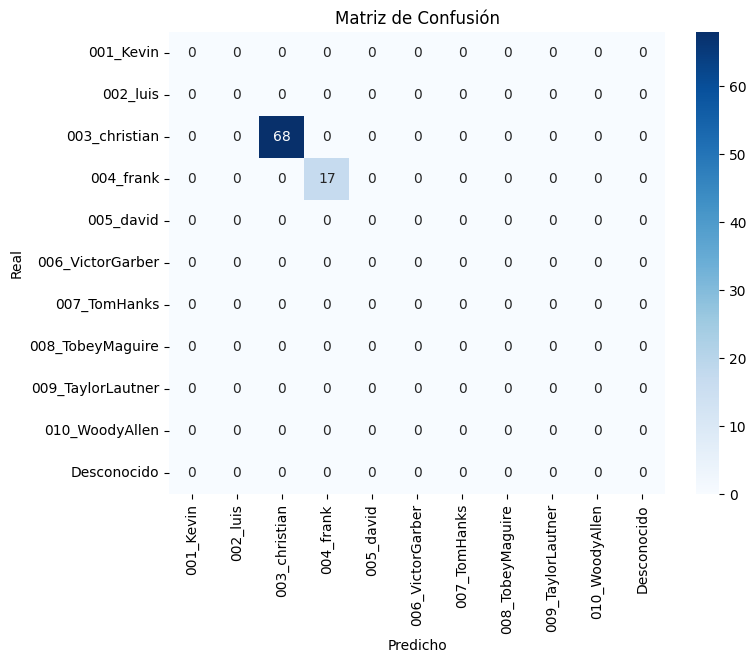

In [18]:
import cv2
import os
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

padding = 100

# Directorio de las imágenes
image_dir = 'D:/taller/dataset'

print("Carpetas en el directorio de imágenes:")
fotos_mias_folders = sorted([folder for folder in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, folder))])
print(fotos_mias_folders)

# Crear un diccionario que mapea la clase según el orden de entrenamiento
class_to_name = {i: folder for i, folder in enumerate(fotos_mias_folders)}
name_to_class = {folder: i for i, folder in class_to_name.items()}  # Mapeo inverso
print("\n🔍 Mapeo de Clases (Inferencia):", class_to_name)

# Verificar el mapeo de clases
print("Mapeo de clases:")
for key, value in class_to_name.items():
    print(f"Índice {key}: {value}")

# Cargar el modelo de predicción
model_facial = load_model('redes_entrenadas/ReconocimientoFacialV02.h5')

# Inicializar MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Inicializar la captura de video
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 540)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 400)
cap.set(cv2.CAP_PROP_FPS, 60)

if not cap.isOpened():
    print("Error: No se pudo abrir la cámara.")
    exit()

# Listas para la matriz de confusión
y_true = []  # Etiquetas reales
y_pred = []  # Etiquetas predichas

total_classes = len(class_to_name) + 1  # Agregamos una clase extra para "Desconocido"

def identificar_usuario(face):
    try:
        face_resized = cv2.resize(face, (128, 128))
        face_resized = face_resized.astype('float32') / 255.0
        face_resized = np.expand_dims(face_resized, axis=0)
        
        usuario = model_facial.predict(face_resized)
        clase_predicha = np.argmax(usuario, axis=1)[0]
        
        if clase_predicha not in class_to_name:
            return "Desconocido"
        
        return class_to_name[clase_predicha]
    except Exception as e:
        print(f"Error al identificar usuario: {e}")
        return "Desconocido"

def reconocer_rostro(face, clase_real):
    try:
        face_resized = cv2.resize(face, (128, 128))
        face_resized = face_resized.astype('float32') / 255.0 
        face_resized = np.expand_dims(face_resized, axis=0)

        usuario = model_facial.predict(face_resized)
        probabilidad = np.max(usuario) * 100
        clase_predicha = np.argmax(usuario, axis=1)[0]

        print("\n🔹 Predicción Cruda:", usuario)
        print(f"🔹 Clase Predicha: {clase_predicha}, Probabilidad: {probabilidad:.2f}%")

        if clase_predicha not in class_to_name:
            return "Desconocido", 0, total_classes

        user_name = class_to_name[clase_predicha]
        
        clase_real_idx = name_to_class.get(clase_real, -1)
        if clase_real_idx == -1:
            print(f"⚠️ Advertencia: Clase real '{clase_real}' no encontrada en el dataset.")

        if probabilidad < 75:
            user_name = "Desconocido"
            clase_predicha = total_classes

        print("Predicción bruta del modelo:", usuario)

        y_true.append(clase_real_idx)
        y_pred.append(clase_predicha)

        return user_name, probabilidad, clase_predicha
    except Exception as e:
        print(f"Error al predecir el modelo: {e}")
        return "Desconocido", 0, total_classes

while True:
    ret, frame = cap.read()
    if not ret:
        print("Error: No se pudo leer el fotograma.")
        break

    frame = cv2.flip(frame, 1)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb_frame)

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            ih, iw, _ = frame.shape
            x_min = iw
            y_min = ih
            x_max = 0
            y_max = 0

            for landmark in face_landmarks.landmark:
                x, y = int(landmark.x * iw), int(landmark.y * ih)
                x_min = min(x_min, x)
                y_min = min(y_min, y)
                x_max = max(x_max, x)
                y_max = max(y_max, y)

            x, y, w, h = x_min, y_min, x_max - x_min, y_max - y_min
            face = frame[y:y+h, x:x+w]
            if face.size > 0:
                clase_real = identificar_usuario(face)
                nombre, confianza, clase_predicha = reconocer_rostro(face, clase_real)
                confianza = round(confianza, 3)

            cv2.putText(frame, f"Usuario: {nombre} ({confianza}%) Clase: {clase_predicha}", (x, y - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)

    cv2.imshow('Reconocimiento Facial', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Generar y mostrar la matriz de confusión
y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred, labels=list(range(total_classes)))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(class_to_name.values()) + ["Desconocido"], 
            yticklabels=list(class_to_name.values()) + ["Desconocido"])
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()


In [ ]:
# Para visualizar los resultados de TensorBoard
%load_ext tensorboard
%tensorboard --logdir logs/fit